In [6]:
!pip install 'plenopticam>=0.7.0'

In [14]:
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

try:
	import plenopticam as pcam
except ImportError:
	print('run-> python3 -m pip install plenopticam>=0.7.0')

def lf_decode_sans_save(lfp_path, cal_path, full_sai = True, central_view_extract_dim = 3):
	#Configuration
	cfg = pcam.cfg.PlenopticamConfig()
	cfg.default_values()
	cfg.params[cfg.lfp_path] = lfp_path
	cfg.params[cfg.cal_path] = cal_path
	cfg.params[cfg.opt_cali] = True
	cfg.params[cfg.ptc_leng] = 13
	cfg.params[cfg.cal_meth] = pcam.cfg.constants.CALI_METH[3]
	sta = pcam.misc.PlenopticamStatus()

	#reading raw LF
	reader = pcam.lfp_reader.LfpReader(cfg, sta)
	reader.main()
	lfp_img = reader.lfp_img

	#finding appropriate white image in the calibration data
	cal_finder = pcam.lfp_calibrator.CaliFinder(cfg, sta)
	ret = cal_finder.main()
	wht_img = cal_finder.wht_bay

	#Micro Image Calibration
	cal_obj = pcam.lfp_calibrator.LfpCalibrator(wht_img, cfg, sta)
	ret = cal_obj.main()
	cfg = cal_obj.cfg

	#Micro Image Alignment
	ret = cfg.load_cal_data()
	aligner = pcam.lfp_aligner.LfpAligner(lfp_img, cfg, sta, wht_img)
	ret = aligner.main()
	lfp_img_align = aligner.lfp_img

	#Extracting Sub Aperture Images
	extractor = pcam.lfp_extractor.LfpExtractor(lfp_img_align, cfg, sta)
	ret = extractor.main()
	vp_img_arr = extractor.vp_img_arr

	view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
	vp_view = view_obj.central_view

	#Extracting all sub aperture views and displaying them
	view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)
	vp_stack = view_obj.views_stacked_img
	vp_stack_out = vp_stack/vp_stack.max()

	if full_sai == True:
		return vp_stack_out


	








 Save raw image
 Progress: Finished 


 Debayering
 Progress: Finished 


 Estimate micro image size
 Progress: Finished 


 Compute LoG
 Progress: Finished 


 Select maxima
 Progress: Finished 


 Refine micro image centers
 Progress: Finished 


 Sort micro image centers
 Progress: Finished 


 Grid fitting
 Progress: Finished 


 Save calibration data
 Progress: Finished 


 Hot pixel detection
 Progress: Finished 


 Debayering
 Progress: Finished 


 Light-field alignment
 Progress: 100%
 Save aligned light-field

 Potential data loss as directory already exists.
 Progress: Finished 


 Render angular domain
 Progress: Finished 


 Viewpoint composition
 Progress: Finished 


 Color equalization
 Progress: Finished 


 Write viewpoint images
 Progress: Finished 


 Compute depth map
 Progress: Finished 


 Write depth data
 Progress: Finished 



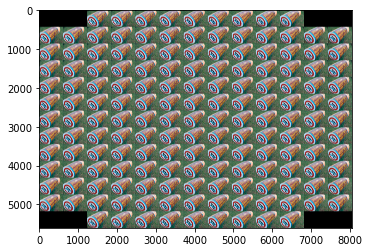

In [15]:
#loader = pcam.misc.DataDownloader()
#loader.download_data(loader.host_eu_url, fp='Data')
#loader.extract_archive(archive_fn='Data/illum_test_data.zip', fname_list='lfr')
lfp_path = '/content/drive/MyDrive/EE5176/IMG_1544.lfr'
calibration_path = '/content/drive/MyDrive/EE5176/caldata-B5152300590.tar'
#function call. desired output = decoded_views_all
decoded_views_all = lf_decode_sans_save(lfp_path, calibration_path)
#visualization of results
plt.imshow(decoded_views_all)
plt.show()

In [16]:
from imageio import imread, imwrite, mimsave, imsave
imsave('img1544_13_13_decoded_pcam.png', decoded_views_all)

In [17]:
import numpy as np
from imageio import imread, imwrite, mimsave
import os


def make_gif(image_path, savename, duration=1, savedir="./", grid=13, chop=5):
    img = imread(image_path)
    H, W, _ = img.shape
    steph, stepw = H//grid, W//grid
    n_views = grid-(2*chop)
    imgg = img[steph*chop:(H-(steph*chop)),
               stepw*chop:(W-(stepw*chop)), :]
    h, w, _ = imgg.shape
    x, y = h//n_views, w//n_views
    images = []
    images.append(imgg[:x, :y, :])
    images.append(imgg[:x, 2*y:3*y, :])
    images.append(imgg[2*x:3*x, :y, :])
    images.append(imgg[2*x:3*x, 2*y:3*y, :])
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    savename = os.path.join(savedir, savename)
    mimsave(savename, images, duration=duration)

In [19]:
make_gif('/content/img1544_13_13_decoded_pcam.png','thirdgif.gif',1,'/content/gifs')